<center>
<h2>Capstone Project</h2>

# <span style='color: #81A5FF; '> ❔ Defining Personalities through a Predictive Model </span>

<h3> Group 4 </h3>

<span style='color: #081F4F; font-size: 18px;'>2023/2024</span>
</center>


---------

## Table of Contents

The following notebook concerns the manipulation of questionnaire data provided by ChatGPT in an effort to build a classifier able to predict which "Food Personality" a customer fits in, thus consisting of a typical Machine Learning pipeline.

<span style = 'font-size: 18px;'>

[🍽 1. Importing Libraries and Integrating Data](#1-importing-libraries-and-integrating-data) <br>
[🍽 2. Preliminary Exploration of the Data](#2-preliminary-exploration-and-preprocessement)<br>
[🍽 3. Visualizing Patterns](#3-visualization) <br>
[🍽 4. Building the Classifier and Evaluating it](#4-building-the-predictive-model-and-evaluating-it)<br>
[🍽 5. Training and Saving the Final Model](#5-training-and-saving-the-final-model-for-future-predictions)<br>
</span>


---------

## 1. Importing Libraries and Integrating Data

[Back to TOC](#table-of-contents)

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import string


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,  confusion_matrix, classification_report
from sklearn.model_selection import KFold, cross_val_score

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

> Firstly, we will extract the AI generated questionnaire answers, their augmentations and structure all of them together.

In [2]:
#Extracting the AI generated answers
answers = pd.DataFrame()
for personality in os.listdir('data/training_answers/original/'):
    personality_answer = pd.read_csv('data/training_answers/original/' + personality)
    personality_answer['personality'] = personality
    answers = pd.concat([answers,personality_answer])

In [3]:
answers

,Willingness to Try Exotic Foods,Importance of Food Presentation,Value for Money in Meals,Preference for Gourmet Restaurants,Interest in Nutritional Content,Frequency of Eating Home-Cooked Meals,Desire for New Culinary Experiences,Preference for Organic or Diet-Specific Foods,Enjoyment of Traditional or Familiar Foods,Willingness to Spend on High-Quality Ingredients,personality
0,2,3,4,2,3,5,2,3,5,3,comfort_food_lover_responses.csv
1,1,2,3,1,2,4,1,2,4,2,comfort_food_lover_responses.csv
2,2,3,4,2,3,5,2,3,5,3,comfort_food_lover_responses.csv
3,3,2,3,3,2,4,1,4,4,2,comfort_food_lover_responses.csv
4,1,3,4,1,3,5,2,2,5,3,comfort_food_lover_responses.csv
...,...,...,...,...,...,...,...,...,...,...,...
16,3,4,2,2,5,3,3,5,3,3,conscious_eater_responses.csv
17,3,3,3,3,4,4,2,5,2,4,conscious_eater_responses.csv
18,3,4,4,4,5,5,3,5,3,5,conscious_eater_responses.csv
19,3,3,2,2,4,3,2,5,2,3,conscious_eater_responses.csv


In [4]:
#Extracting the augmented answers provided by AI content
answers_aug = pd.DataFrame()
for personality in os.listdir('data/training_answers/aug/'):
    personality_answer = pd.read_csv('data/training_answers/aug/' + personality)
    personality_answer['personality'] = personality
    answers_aug = pd.concat([answers_aug,personality_answer])

In [5]:
answers_aug

,Willingness to Try Exotic Foods,Importance of Food Presentation,Value for Money in Meals,Preference for Gourmet Restaurants,Interest in Nutritional Content,Frequency of Eating Home-Cooked Meals,Desire for New Culinary Experiences,Preference for Organic or Diet-Specific Foods,Enjoyment of Traditional or Familiar Foods,Willingness to Spend on High-Quality Ingredients,personality
0,3,2,4,1,2,4,1,4,4,3,comfort_food_lover_responses_aug.csv
1,1,2,3,1,2,4,1,2,4,2,comfort_food_lover_responses_aug.csv
2,3,2,3,3,2,4,1,4,4,2,comfort_food_lover_responses_aug.csv
3,1,2,3,1,2,4,1,2,4,2,comfort_food_lover_responses_aug.csv
4,2,3,4,2,3,5,2,3,5,3,comfort_food_lover_responses_aug.csv
...,...,...,...,...,...,...,...,...,...,...,...
4995,3,4,4,3,5,4,3,5,3,4,conscious_eater_responses_aug.csv
4996,3,3,2,2,4,3,2,5,2,3,conscious_eater_responses_aug.csv
4997,3,4,3,3,5,4,3,5,3,4,conscious_eater_responses_aug.csv
4998,3,4,4,4,4,5,2,5,2,5,conscious_eater_responses_aug.csv


In [6]:
# Joining the two datasets
total_answers = pd.concat([answers,answers_aug])

In [7]:
# Resetting the index of the dataframe
total_answers.reset_index(inplace=True, drop=True)

In [8]:
# Putting the personality classes in a more readable format
personality_mapping_names = {}
for personality in list(total_answers['personality'].unique()):
    name = personality.split('_')[:-1]
    name_clean = []
    for section in name:
        section = section.capitalize()
        if section != 'Responses':
            name_clean.append(section)
    name_clean = ' '.join(name_clean)
    personality_mapping_names[personality] = name_clean
total_answers['personality'] = total_answers['personality'].map(personality_mapping_names)

In [9]:
# Exporting the total_answers to a CSV file to introduce them to ChatGPT and generate some noisy observations
total_answers.to_csv('data/training_answers/total_answers', index=False)

In [10]:
# Importing the data with additional noise introduced to the answers by ChatGPT
final_answers = pd.read_csv('data/training_answers/perturbed_total_answers.csv')

> Let's add random usernames as identifiers of the observations.

In [11]:
existing_usernames = set() 

def generate_username(length=10):
    characters = string.ascii_letters + string.digits  
    while True:
        username = ''.join(random.choice(characters) for _ in range(length))
        if username not in existing_usernames:
            existing_usernames.add(username)
            return username

# Generating a column with random usernames for the answers
final_answers['username'] = final_answers.apply(lambda x: generate_username(), axis=1)

> Now let's export the processed data for further usage in other phases of the project.

In [12]:
# Exporting the 'final_answers' DataFrame to a CSV file
final_answers.to_csv('data/training_answers/perturbed_total_answers.csv', index=False)

## 2. Preliminary Exploration and Preprocessement

[Back to TOC](#table-of-contents)

In [13]:
final_answers['personality'].value_counts()

personality
Fine Dining Connoisseur    5036
Low Cost Foodie            5025
The Adventurer             5023
Comfort Food Lover         5022
Conscious Eater            5022
Name: count, dtype: int64

> We find that our data is perfectly balanced, making it appropriate to examine metrics such as the accuracy.

In [14]:
final_answers.describe()

,Willingness to Try Exotic Foods,Importance of Food Presentation,Value for Money in Meals,Preference for Gourmet Restaurants,Interest in Nutritional Content,Frequency of Eating Home-Cooked Meals,Desire for New Culinary Experiences,Preference for Organic or Diet-Specific Foods,Enjoyment of Traditional or Familiar Foods,Willingness to Spend on High-Quality Ingredients,Frequency of Home-Cooked Meals
count,25128.000000,25128.000000,25128.000000,25128.000000,25128.000000,25105.000000,25128.000000,25128.000000,25128.000000,25128.000000,23.000000
mean,2.945638,3.098695,3.127348,2.871777,3.290433,3.255885,3.051695,3.476839,3.041189,3.202841,2.782609
std,1.536722,1.529212,1.529463,1.515614,1.487594,1.501356,1.534209,1.455110,1.523830,1.511463,0.735868
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,3.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,3.000000,3.000000,3.000000
75%,4.000000,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000,5.000000,5.000000,5.000000,3.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000


In [15]:
final_answers.drop('username', axis=1).groupby('personality').median()

,Willingness to Try Exotic Foods,Importance of Food Presentation,Value for Money in Meals,Preference for Gourmet Restaurants,Interest in Nutritional Content,Frequency of Eating Home-Cooked Meals,Desire for New Culinary Experiences,Preference for Organic or Diet-Specific Foods,Enjoyment of Traditional or Familiar Foods,Willingness to Spend on High-Quality Ingredients,Frequency of Home-Cooked Meals
personality,,,,,,,,,,,
Comfort Food Lover,2.0,3.0,4.0,2.0,2.0,4.0,2.0,3.0,5.0,2.0,3.0
Conscious Eater,4.0,3.0,3.0,3.0,4.0,4.0,2.0,4.0,3.0,4.0,4.0
Fine Dining Connoisseur,3.0,5.0,2.0,4.0,4.0,2.0,4.0,4.0,2.0,4.0,3.0
Low Cost Foodie,2.0,2.0,5.0,1.0,3.0,3.0,2.0,4.0,3.0,2.0,2.0
The Adventurer,5.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0


> We also find that, in median terms, it is already possible to view some distinctions within clients' answers depending on their assigned personality. For example, Comfort food lovers appreciate more traditional food and home made meals, being less propense to trying exotic foods or experience new culinary items. On the other hand, Conscious Eaters are more willing to spend more on high-quality ingredients and interested in nutritial content in comparison to the remaining personalities.

In [16]:
# Checking the null values
final_answers.isnull().any()

Willingness to Try Exotic Foods                     False
Importance of Food Presentation                     False
Value for Money in Meals                            False
Preference for Gourmet Restaurants                  False
Interest in Nutritional Content                     False
Frequency of Eating Home-Cooked Meals                True
Desire for New Culinary Experiences                 False
Preference for Organic or Diet-Specific Foods       False
Enjoyment of Traditional or Familiar Foods          False
Willingness to Spend on High-Quality Ingredients    False
personality                                         False
username                                            False
Frequency of Home-Cooked Meals                       True
dtype: bool

> Since there are no missing values, it is not necessary to perform any kind of imputations.

In [17]:
# Dropping the null values
final_answers[final_answers.drop('username', axis=1).duplicated()]

,Willingness to Try Exotic Foods,Importance of Food Presentation,Value for Money in Meals,Preference for Gourmet Restaurants,Interest in Nutritional Content,Frequency of Eating Home-Cooked Meals,Desire for New Culinary Experiences,Preference for Organic or Diet-Specific Foods,Enjoyment of Traditional or Familiar Foods,Willingness to Spend on High-Quality Ingredients,personality,username,Frequency of Home-Cooked Meals
748,1,5,2,1,2,3.0,1,5,5,5,Comfort Food Lover,exnO0tg6yQ,NaN
999,2,4,4,2,3,5.0,1,3,5,1,Comfort Food Lover,sKKpAyFMhZ,NaN
1313,1,1,2,1,1,5.0,3,4,5,1,Comfort Food Lover,pEYhIZnZb7,NaN
1480,4,2,5,4,2,5.0,3,5,5,1,Comfort Food Lover,bsqo2qyLly,NaN
1675,1,4,5,4,4,5.0,3,5,5,2,Comfort Food Lover,PyyJ07wALy,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25118,3,3,3,3,3,NaN,3,3,3,3,Fine Dining Connoisseur,B275iQbOl5,3.0
25119,3,3,3,3,3,NaN,3,3,3,3,Fine Dining Connoisseur,eBxzjykDWU,3.0
25120,3,3,3,3,3,NaN,3,3,3,3,Fine Dining Connoisseur,e1NoGuQgNG,3.0
25121,3,3,3,3,3,NaN,3,3,3,3,Fine Dining Connoisseur,0diJijFGQf,3.0


> There are also a few duplicated observations. However, since these represent answers per customer, and there may be customers with equal answers, the duplicates will be kept.

## 3. Visualization

[Back to TOC](#table-of-contents)

> Firstly let's understand how do the answers to the questionnaire typically correlate to eachother.

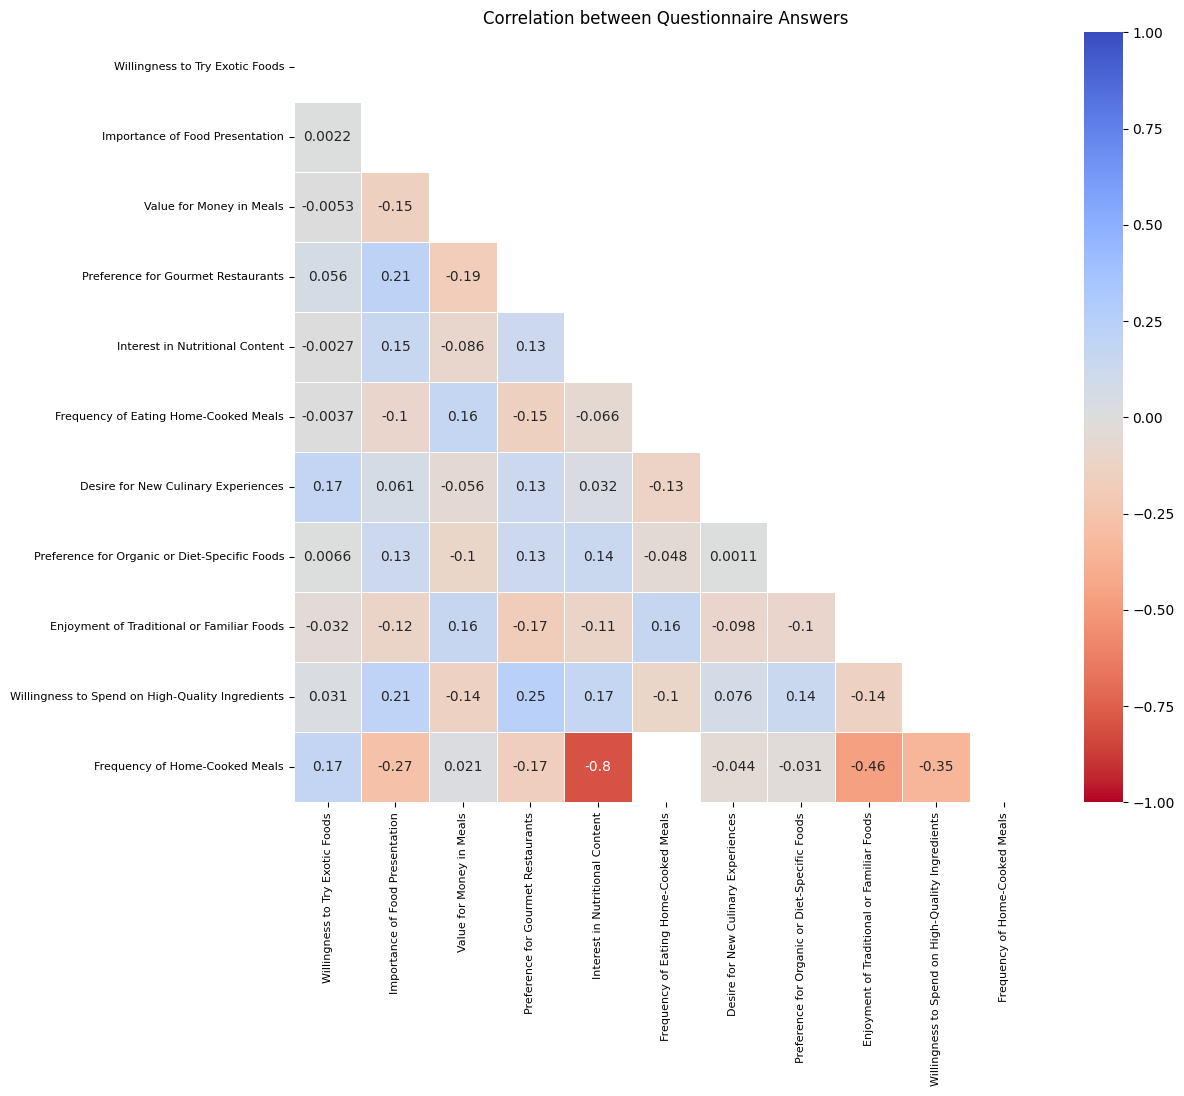

In [18]:
correlation_matrix = final_answers.drop(['personality', 'username'], axis=1).corr(method='spearman')

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, mask=mask,annot=True, cmap='coolwarm_r', linewidths=.5, vmin=-1, vmax=1)
# Reduce the font size of the labels.
plt.xticks(fontsize=8)  # Adjust the font size for x-axis labels.
plt.yticks(fontsize=8)  # Adjust the font size for y-axis labels.
plt.title("Correlation between Questionnaire Answers")
plt.show()

> It appears that there are several factors that typically are found together, namely the preference for gourmet restaurants, the importance given to the presentation of a meal and the willingness to spend on high quality ingredients. Moreover, it seems that clients who prefer home-cooked meals are not so enthusiastic of new culinary experiences, while the preference for gourmet restaurants typically implies less preoccupation with the monetary value of the meal.

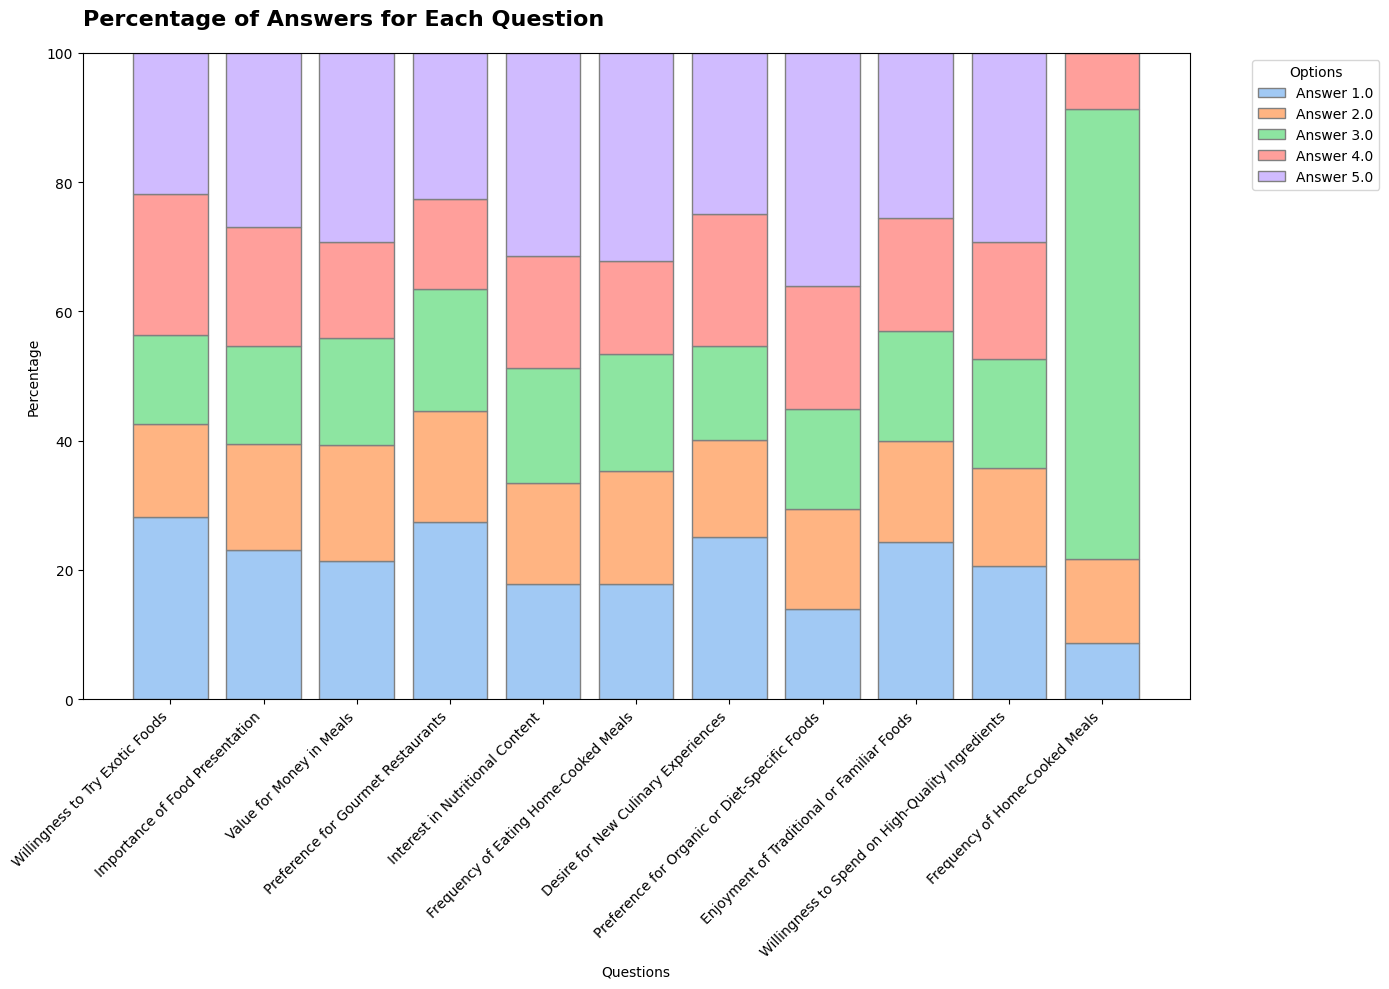

In [19]:
rating_counts = final_answers.drop(['personality', 'username'], axis=1).apply(pd.Series.value_counts)

total_responses = final_answers.drop(['personality', 'username'], axis=1).count()

feature_percentages = (rating_counts / total_responses) * 100

feature_percentages = feature_percentages.T

feature_percentages.fillna(0, inplace=True)

plt.figure(figsize=(14, 10))

bottoms_corrected = pd.Series([0]*len(feature_percentages), index=feature_percentages.index)
colors = sns.color_palette("pastel")

for i, column in enumerate(feature_percentages.columns):
    plt.bar(feature_percentages.index, feature_percentages[column], 
            bottom=bottoms_corrected, label=f'Answer {column}', color=colors[i % len(colors)], edgecolor='gray')
    bottoms_corrected += feature_percentages[column]

plt.title('Percentage of Answers for Each Question', fontsize=16, fontweight='bold', pad=20, loc='left')
plt.xlabel('Questions')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha="right")
plt.legend(title='Options', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

> Interpretação

In [20]:
melted = pd.melt(final_answers.drop('username', axis=1), id_vars='personality', value_name='Answer', var_name='Question')

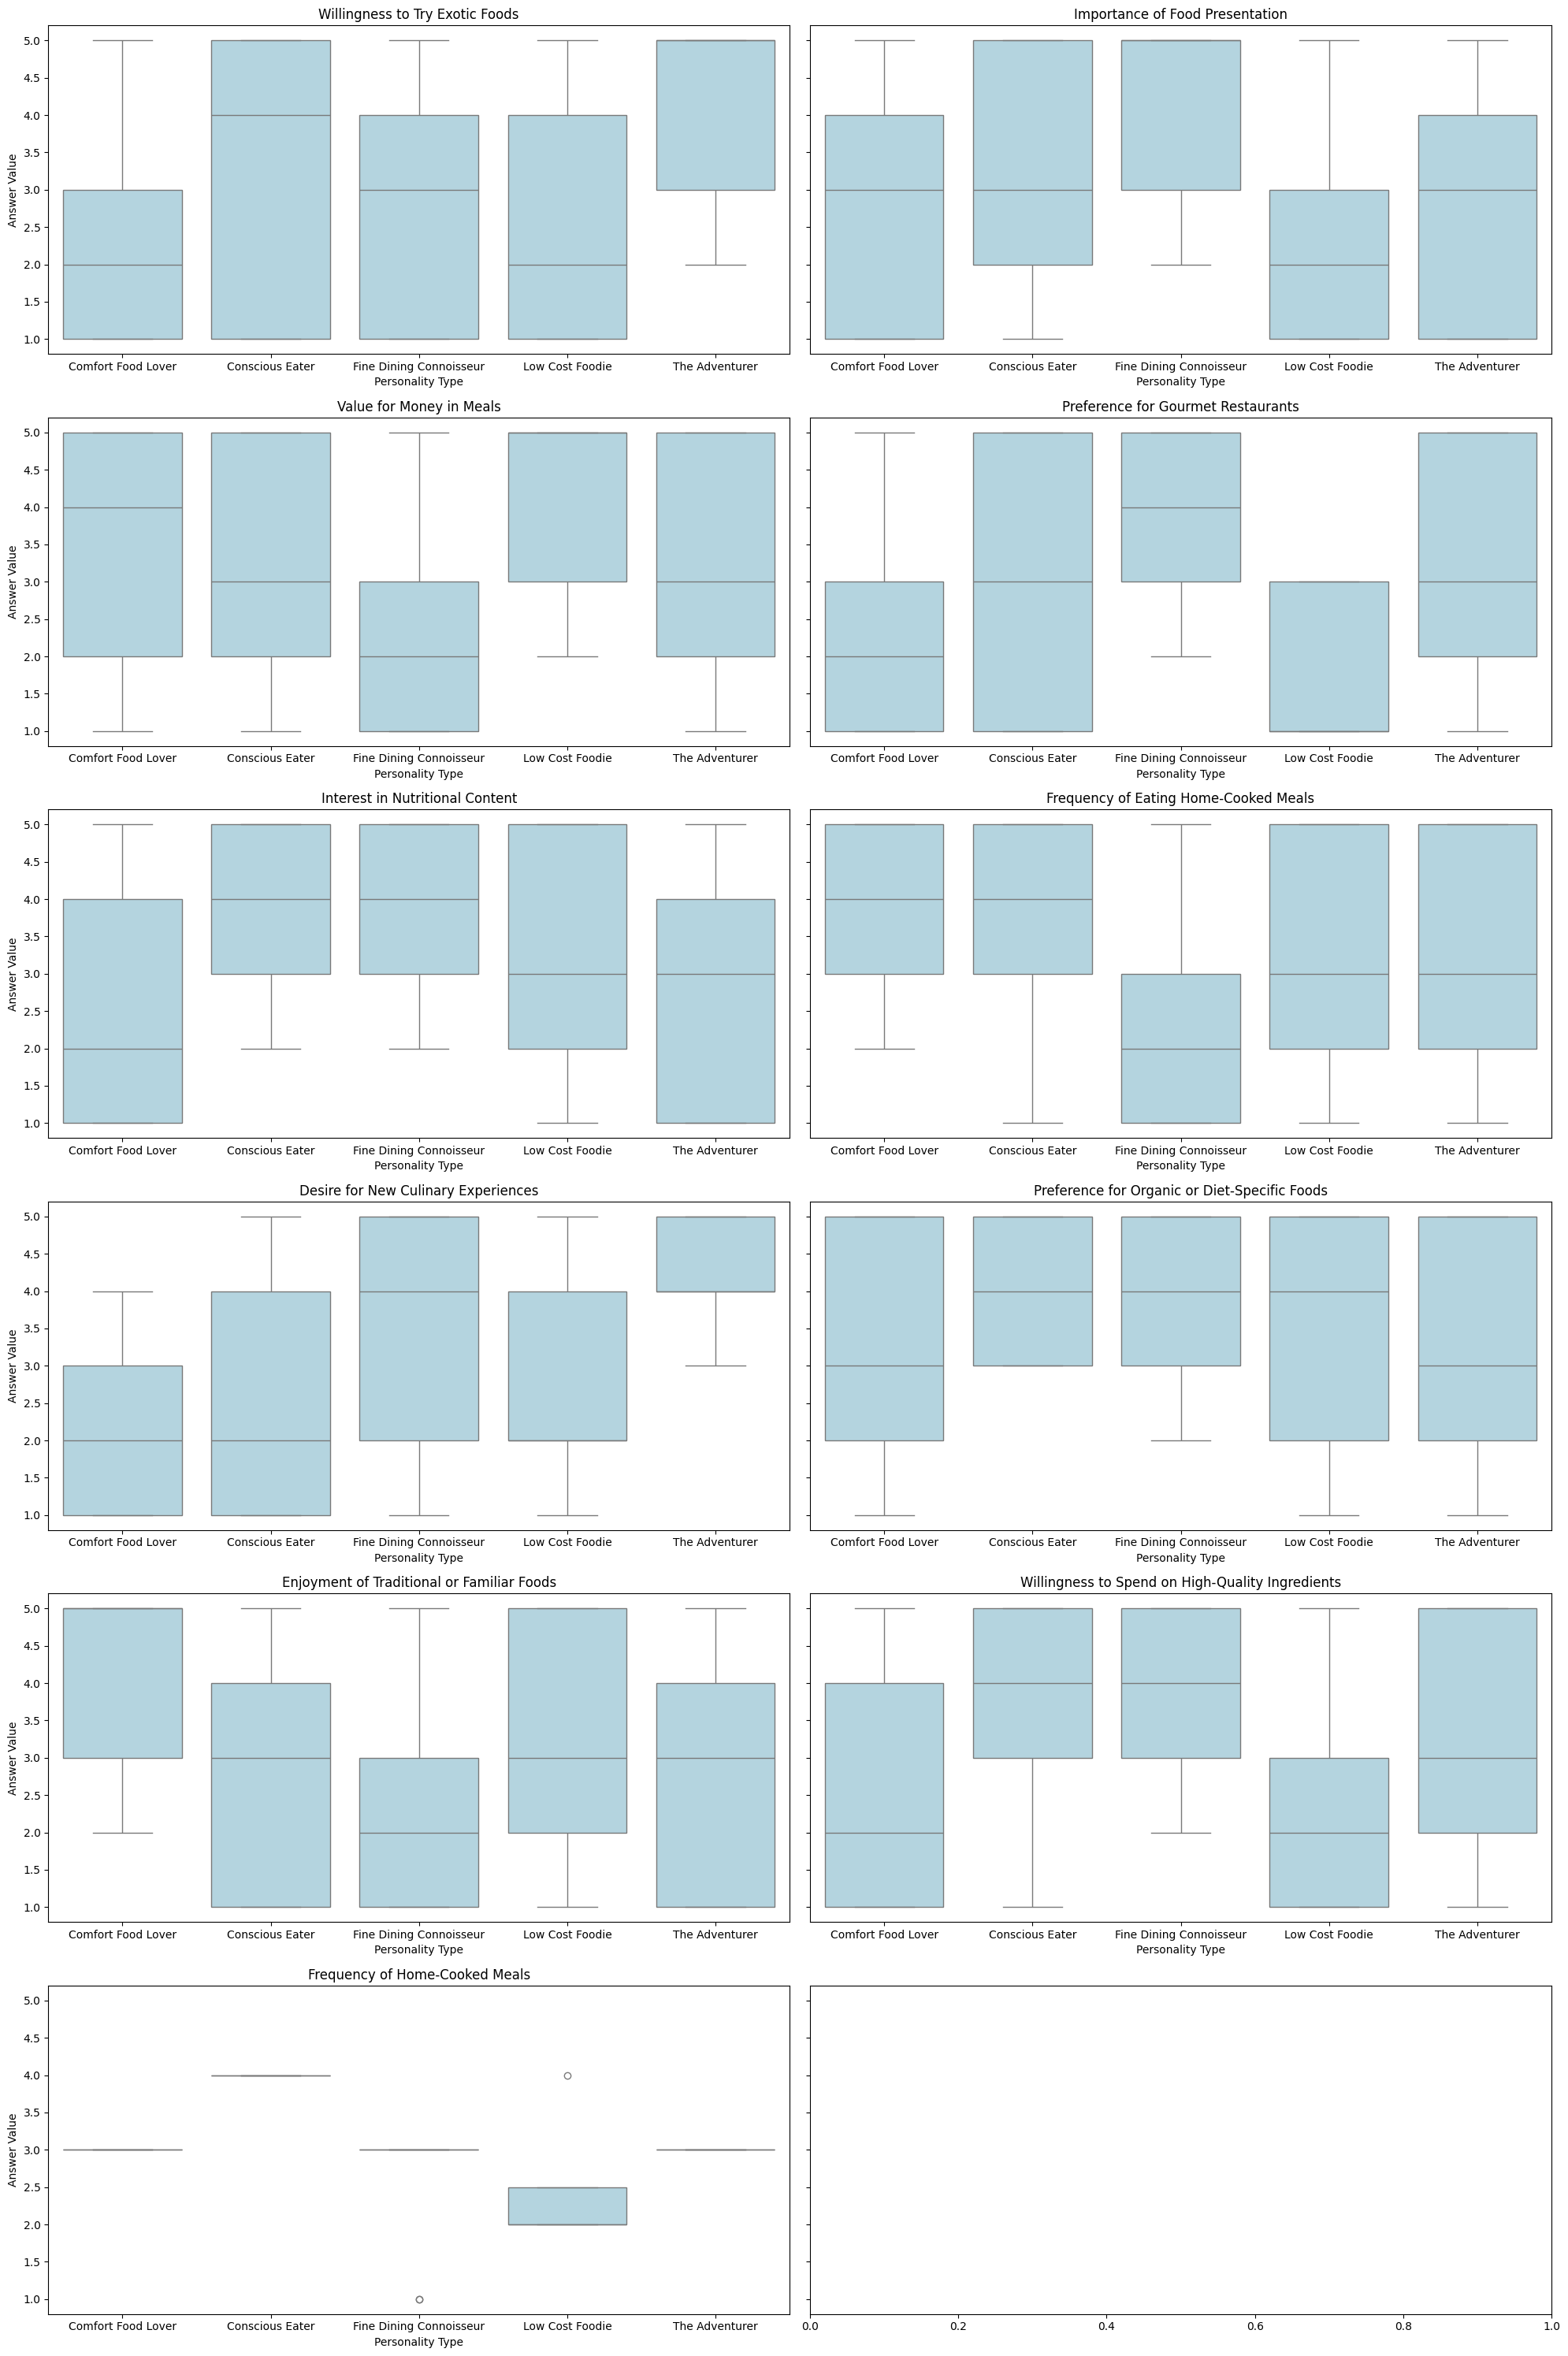

In [21]:
questions = list(melted['Question'].unique())

fig, axes = plt.subplots(6, 2, figsize=(20, 30), sharey=True)
axes = axes.flatten()

for i in range(0, len(questions) ):
    ax = axes[i]
    sns.boxplot(data=melted[melted['Question'] == f'{questions[i]}'], x='personality', y='Answer', ax=ax , color= 'lightblue')
    ax.set_title(f'{questions[i]}')
    ax.set_xlabel('Personality Type')
    ax.set_ylabel('Answer Value')

plt.tight_layout()

plt.show()

## 4. Building the Predictive Model and Evaluating it

[Back to TOC](#table-of-contents)

> Let's first separate the target variable from the features.

In [22]:
X = final_answers.drop(['personality', 'username'], axis=1)
y = final_answers['personality']

> To evaluate the model consistently, K-Fold cross-validation will be used.

In [23]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_val_scores = []
accuracy_train_scores = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
     print(f" -----------  Training for Fold {i} ----------- ")
     X_train, X_val = X.iloc[train_index], X.iloc[test_index]
     y_train, y_val = y.iloc[train_index], y.iloc[test_index]
     rf = RandomForestClassifier(n_estimators=150, max_depth=15, random_state=42, min_samples_leaf=10, criterion='gini')
     rf.fit(X_train, y_train)
     y_train_pred = rf.predict(X_train)
     y_val_pred = rf.predict(X_val)
     accuracy_val_scores.append(accuracy_score(y_val, y_val_pred))
     accuracy_train_scores.append(accuracy_score(y_train, y_train_pred))
     print(f"Train Accuracy Score: {accuracy_train_scores[i]}")
     print(f"Validation Accuracy Score: {accuracy_val_scores[i]}")
     print(f"Classification Report: \n {classification_report(y_val, y_val_pred)}")
print(f"Average Training Accuracy Score: {np.mean(accuracy_train_scores)}")
print(f"Average Validation Accuracy Score: {np.mean(accuracy_val_scores)}")

 -----------  Training for Fold 0 ----------- 


ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

> Now that we found a moderately-accurate model, with approximately, and on average, an 80% of accuracy in the validation set, let's examine the confusion matrix of the last fold's validation predictions to get a better understanding of which classes the model is able to capture best.

In [ ]:
classes = list(y.unique())
matrix = confusion_matrix(y_val, y_val_pred)
row_totals = matrix.sum(axis=1)
matrix_percentages = matrix / row_totals[:, None] * 100 
#Create DataFrames from the confusion matrices
df_confusion = pd.DataFrame(matrix, index=classes, columns=classes)
df_percentages = pd.DataFrame(matrix_percentages, index=classes, columns=classes)
annotations = df_confusion.astype(str) + "\n" + df_percentages.round(2).astype(str) + "%"

NameError: name 'y' is not defined

In [43]:
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=annotations, fmt='', cmap='Blues', annot_kws={"size": 12}, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Personality')
plt.ylabel('Actual Personality')
plt.title('Confusion Matrix with Percentages')
plt.show()

NameError: name 'matrix' is not defined

<Figure size 1000x800 with 0 Axes>

> It appears that the model is being able to capture relatively well the distinction between different personalities, performing less accurately for observations within "Comfort Food Lover" personality, often confusing it with "Low Cost Foodies". 

## 5. Training and Saving the final model for Future Predictions

[Back to TOC](#table-of-contents)

> Now that the model's parameters are defined, it will be trained on the entire data and saved for future predictions.

In [111]:
rf = RandomForestClassifier(n_estimators=150, max_depth=15, random_state=42, min_samples_leaf=10, criterion='gini')
rf.fit(X, y)

RandomForestClassifier(max_depth=15, min_samples_leaf=10, n_estimators=150,
                       random_state=42)

In [112]:
with open('personality_classification_model.pkl', 'wb') as f:
    pickle.dump(rf, f)